# MNIST
- [Kaggle digit-recognizer](https://www.kaggle.com/competitions/digit-recognizer)

## imports

In [1]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning import Trainer, LightningModule, LightningDataModule
from pytorch_lightning.callbacks import EarlyStopping

## arguments 설정

In [2]:
import argparse

args = argparse.Namespace(
    dataset_path = "../dataset/digit-recognizer",
    
    max_epoch = 200,
    batch_size = 128,
    lr = 0.0001,
)

## 데이터 불러오기

In [3]:
import numpy as np
import pandas as pd

In [4]:
train_df = pd.read_csv(os.path.join(args.dataset_path, "train.csv"))
test_df = pd.read_csv(os.path.join(args.dataset_path, "test.csv"))
submission_df = pd.read_csv(os.path.join(args.dataset_path, "sample_submission.csv"))

print(f"shape of train_df : {train_df.shape}")
print(f"shape of test_df : {test_df.shape}")
print(f"shape of submission_df : {submission_df.shape}")

train_df.head()

shape of train_df : (42000, 785)
shape of test_df : (28000, 784)
shape of submission_df : (28000, 2)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### train 데이터에서 label 분리

In [5]:
train_x = train_df.loc[:, train_df.columns != "label"].to_numpy()
test_x = test_df.to_numpy()
train_y = train_df["label"].to_numpy()

print(f"train_x : {train_x.shape}")
print(f"train_y : {train_y.shape}")
print()
print(f"test_x : {test_x.shape}")

train_x : (42000, 784)
train_y : (42000,)

test_x : (28000, 784)


### train_x (image)의 shape을 28 * 28로 변경

In [6]:
train_x = train_x.reshape((-1, 28, 28))
test_x = test_x.reshape((-1, 28, 28))
print(f"train_x : {train_x.shape}")
print(f"test_x : {test_x.shape}")

train_x : (42000, 28, 28)
test_x : (28000, 28, 28)


### train 이미지 확인

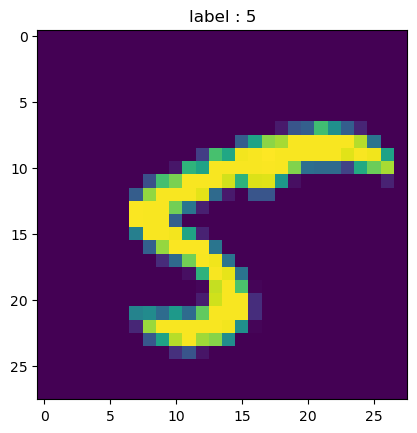

In [7]:
idx = np.random.randint(0, train_x.shape[0])
plt.title(f"label : {train_y[idx]}")
plt.imshow(train_x[idx])
plt.show()

## Dataset, DataModule 구성

### Dataset 클래스

In [8]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None):
        super().__init__()
        self.images = images
        self.labels = labels
    
    def __getitem__(self, index):    
        image = self.images[index]
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.labels is None:
            return image
        
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label
    
    def __len__(self):
        return len(self.images)

### DataModule 클래스

In [9]:
class MNISTDataModule(LightningDataModule):
    def __init__(self, train_images, train_labels, test_images, batch_size):
        super().__init__()
        self.train_images = train_images
        self.train_labels = train_labels
        self.test_images = test_images
        self.batch_size = batch_size
    
    def setup(self, stage):
        if stage == "fit":
            self.train_dataset, self.val_dataset = random_split(MNISTDataset(self.train_images, self.train_labels), [0.8, 0.2])
        if stage == "predict":
            self.test_dataset = MNISTDataset(self.test_images)
        if stage == "validate":
            self.train_dataset, self.val_dataset = random_split(MNISTDataset(self.train_images, self.train_labels), [0.8, 0.2])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)
    
    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

## Model 구성

### CNN (acc: 98%)

In [10]:
class CNNModel(LightningModule):
    def __init__(self, lr):
        super().__init__()
        self.lr = lr
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = torch.flatten(x, start_dim=1)
        x = F.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        
        metrics = {}
        metrics["train_loss"] = loss
        self.log_dict(metrics)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        
        acc = np.mean(list(map(int, np.argmax(y_hat, axis=1)==y)))
        
        metrics = {}
        metrics["val_loss"] = loss
        metrics["val_acc"] = acc
        self.log_dict(metrics)
        
        return metrics
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## 학습

### 학습하기 전, images의 shape을 batch_size * 1 * N * N 형태로 수정

In [11]:
train_x = train_x.reshape(-1, 1, 28, 28)
test_x = test_x.reshape(-1, 1, 28, 28)

train_x.shape, train_y.shape, test_x.shape

((42000, 1, 28, 28), (42000,), (28000, 1, 28, 28))

In [12]:
model = CNNModel(lr=args.lr)
mnist_data = MNISTDataModule(train_x, train_y, test_x, args.batch_size)
trainer = Trainer(callbacks=EarlyStopping(monitor="val_acc", mode="max", verbose=True, patience=5))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 초기 상태에 10% 정도의 정확도를 보이는 모습 (숫자 0~9)

In [13]:
trainer.validate(model, mnist_data)

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.11321428571428571
        val_loss             7.28122091293335
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 7.28122091293335, 'val_acc': 0.11321428571428571}]

### fit

In [14]:
trainer.fit(model, mnist_data)

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 320   
1 | conv2 | Conv2d | 8.2 K 
2 | fc1   | Linear | 51.3 K
3 | fc2   | Linear | 4.1 K 
4 | fc3   | Linear | 330   
---------------------------------
64.3 K    Trainable params
0         Non-trainable params
64.3 K    Total params
0.257     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.795


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.086 >= min_delta = 0.0. New best score: 0.880


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.030 >= min_delta = 0.0. New best score: 0.910


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.019 >= min_delta = 0.0. New best score: 0.929


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.935


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.941


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.951


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.957


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.962


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.964


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.965


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.968


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.969


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.970


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.970


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.973


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.973


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.977


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.977. Signaling Trainer to stop.


In [15]:
predicted = trainer.predict(model, mnist_data)

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 263it [00:00, ?it/s]

In [16]:
predicted = np.argmax(torch.cat(predicted, dim=0), axis=1)

In [17]:
submission_df["Label"] = predicted

In [18]:
submission_df.to_csv("submission.csv", index=False, quoting=3)